<a href="https://colab.research.google.com/github/Dopamine-Max/CNN-Milestone-projects/blob/main/Cifar10_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# #1 CNN MILESTONE PROJECT
##Importing and Classifying the Cifar10 Dataset
####Builiding a CNN that classifies the 10 categories of images in the Cifar10 dataset having splits for train, development and test from the data.

In [ ]:
# import libraries

import numpy as np
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-a561a675aacf>:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# # transformations and importing the data
# #(this splitting of data failed in providing accuracy on par with the one using seperate cifar sets for training and development)

# cdata = torchvision.datasets.CIFAR10(root='./data', download=True)

# data = cdata.data
# labels = cdata.targets

# #normalize the data to a range of [0 1]
# dataNorm = data / np.max(data)

# #convert to torch tensor format
# dataT   = torch.tensor( dataNorm ).float()
# labelsT = torch.tensor( labels ).long()

# #reshape the data
# dataT = dataT.reshape([50000,3,32,32]).float()

# #Step 1: split the data twice
# train_data,devtest_data,train_labels,devtest_labels = train_test_split(dataT, labelsT, train_size=40000)
# dev_data,test_data,dev_labels,test_labels = train_test_split(devtest_data, devtest_labels, train_size=6000)

# #Step 2: convert into PyTorch Datasets
# train_data = TensorDataset(train_data,train_labels)
# dev_data = TensorDataset(dev_data,dev_labels)
# test_data  = TensorDataset(test_data,test_labels)

# #Step 3: translate into dataloader objects
# train_loader = DataLoader(train_data,batch_size=200,shuffle=True,drop_last=True)
# dev_loader   = DataLoader(dev_data,  batch_size=30,shuffle=True)
# test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [ ]:
# transformations and importing the data (another way of splitting/importing the data)

transforms = T.Compose([
                      T.RandomHorizontalFlip(p=.5),
                      T.ToTensor()#,
                      # T.Normalize([.5,.5,.5],[.5,.5,.5])
                      ])

#import the data and simultaneously apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transforms)
devtest  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)

#split the devtest into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
devset  = Subset(devtest,randidx[:6000]) # Subset for devset
testset = Subset(devtest,randidx[6000:]) # Subset for test

#transform to dataloaders
train_loader = DataLoader(trainset,batch_size=250,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=30,shuffle=True)
test_loader  = DataLoader(testset, batch_size=len(testset))

100%|██████████| 170498071/170498071 [00:05<00:00, 29212169.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


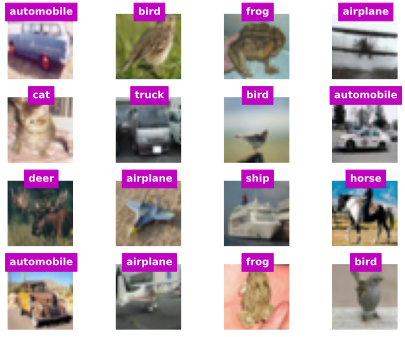

In [ ]:
# inspect a few images
X,y = next(iter(train_loader))

fig,axs = plt.subplots(4,4)

for (i,ax) in enumerate(axs.flatten()):

  #extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  # pic = pic/2 + .5 # undo normalization

  #and its label
  label = trainset.classes[y[i]]

  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='w',backgroundcolor='m')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# create a class for the model
def maketheNet():

  class cifar10net(nn.Module):
    def __init__(self):
      super().__init__()

      self.enc = nn.Sequential(

          #first convolution layer
          nn.Conv2d(3,64,3,padding=1),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(),
          nn.MaxPool2d(2,2),
          nn.Dropout(0.1),

          #second convolution layer
          nn.Conv2d(64,128,3,padding=1),
          nn.BatchNorm2d(128),
          nn.LeakyReLU(),
          nn.MaxPool2d(2,2),
          nn.Dropout(0.15),

          # third convolution layer
          nn.Conv2d(128,256,3,padding=1),
          nn.BatchNorm2d(256),
          nn.LeakyReLU(),
          nn.MaxPool2d(2,2),
          nn.Dropout(0.2),

          #linear layers
          nn.Flatten(), #vectorise conv output
          nn.Linear(4*4*256,10)
          # nn.Linear(3*3*256,512),
          # nn.LeakyReLU(),
          # nn.Dropout(0.5),
          # nn.Linear(512,10)

      )

    def forward(self,x):
      return self.enc(x)

  #create the model instance
  net = cifar10net()

  #loss function
  lossfun = nn.CrossEntropyLoss()

  #optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer


In [ ]:
#### __________SELF-DEFINED ARCHITECTURE_____________________

#   #first convolution layer
    #   self.conv1  = nn.Conv2d(3,32,3,padding=1)
    #   self.bnorm1 = nn.BatchNorm2d(32) # input the number of channels in this layer
    #   #output size: (32+2*1-3)/1 + 1 = 32/2 = 16 (/2 b/c maxpool)

    #   #second convolution layer
    #   self.conv2  = nn.Conv2d(32,64,3)
    #   self.bnorm2 = nn.BatchNorm2d(64) # input the number of channels in this layer
    #   #output size: (16+2*0-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

    #   # third convolution layer
    #   self.conv3  = nn.Conv2d(64,128,3)
    #   self.bnorm3 = nn.BatchNorm2d(128) # input the number of channels in this layer
    #   #output size: (7+2*0-3)/1 + 1 = 5/2 = 3 (/2 b/c maxpool)

    #   #linear layers
    #   self.reshape = nn.Flatten()
    #   self.fc1 = nn.Linear(2*2*128,512)
    #   self.fc2 = nn.Linear(512,10)

    # def forward(self,x):

    #   #first block: convolution -> maxpool -> batchnorm -> relu
    #   x = F.max_pool2d(self.conv1(x),2)
    #   x = F.relu(self.bnorm1(x))

    #   #second block: convolution -> maxpool -> batchnorm -> relu
    #   x = F.max_pool2d(self.conv2(x),2)
    #   x = F.relu(self.bnorm2(x))

    #   #third block: convolution -> maxpool -> batchnorm -> relu
    #   x = F.max_pool2d(self.conv3(x),2)
    #   x = F.relu(self.bnorm3(x))

    #   #linear layers
    #   x = self.reshape(x)
    #   x = F.relu(self.fc1(x))
    #   x = F.dropout(x,p=.5,training=self.training)
    #   x = self.fc2(x)

In [ ]:
# test the model with one batch
net,lossfun,optimizer = maketheNet()

X,y = next(iter(train_loader))
yHat = net(X)

#check size of output
print('\nOutput size:')
print(yHat.shape)

#now compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([250, 10])
 
Loss:
tensor(2.5535, grad_fn=<NllLossBackward0>)


In [ ]:
# count the total number of parameters in the model
net.to(device)
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
           Dropout-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
       BatchNorm2d-7          [-1, 128, 16, 16]             256
         LeakyReLU-8          [-1, 128, 16, 16]               0
         MaxPool2d-9            [-1, 128, 8, 8]               0
          Dropout-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
      BatchNorm2d-12            [-1, 256, 8, 8]             512
        LeakyReLU-13            [-1, 256, 8, 8]               0
        MaxPool2d-14            [-1, 25

In [ ]:
#function that trains the model

def traincifar10net():

  #declare epochs and create the model
  epochs = 25
  net,loss_func,optimizer = maketheNet()

  #send the model to GPU
  net.to(device)

  #intialize losses and accuracies
  trainloss = torch.zeros(epochs)
  devloss = torch.zeros(epochs)
  trainAcc = torch.zeros(epochs)
  devAcc = torch.zeros(epochs)

  #loop over epochs
  for epochi in range(epochs):

    #loop over training batches
    net.train() # switch to train mode
    batchAcc = []
    batchLoss = []
    for X,y in train_loader:

      #push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = loss_func(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item()) #this and any further .item() are for transfer of gpu stored data to cpu

      #compute accuracy
      batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item())
    #end of batch loop

    #average training accuracy across batches
    trainAcc[epochi] = np.mean(batchAcc)
    #average loss across batches
    trainloss[epochi] = np.mean(batchLoss)

    #devset computation
    net.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    for X,y in dev_loader:

      #push data to GPU
      X = X.to(device)
      y = y.to(device)

      #forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,y)

      #loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item())

    #and get average losses and accuracies across the batches
    devloss[epochi] = np.mean(batchLoss)
    devAcc[epochi]  = np.mean(batchAcc)

  #end of epochs

  return trainloss,devloss,trainAcc,devAcc,net

In [ ]:
# train the model ~7 minutes
trainLoss,devLoss,trainAcc,devAcc,net = traincifar10net()

In [ ]:
# the test set

X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

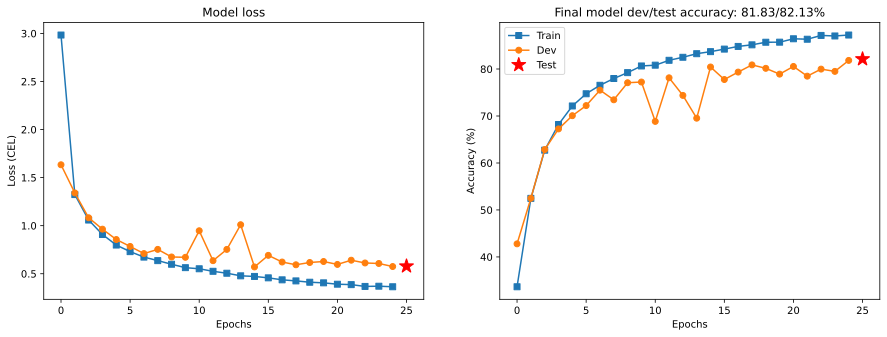

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss),testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc),testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()